In [84]:
import numpy as np 
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
train_data = pd.read_csv("C:\\Users\\lenovo\\Desktop\\HandDigitdataset\\train.csv")
test_data = pd.read_csv("C:\\Users\\lenovo\\Desktop\\HandDigitdataset\\test.csv")

In [67]:
print(train_data.shape[0])

42000


In [68]:
print(train_data.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


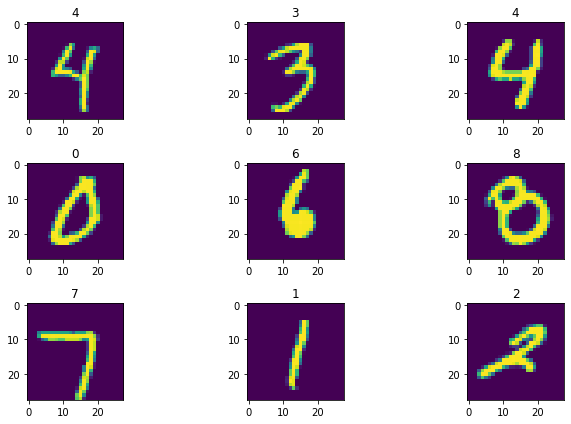

In [69]:
def show_image(train_image, label, index):
    image_shaped = train_image.values.reshape(28,28)
    plt.subplot(3, 3, index+1)
    plt.imshow(image_shaped)
    plt.title(label)


plt.figure(figsize=(10, 6))
sample_image = train_data.sample(9).reset_index(drop=True)
for index, row in sample_image.iterrows():
    label = row['label']
    image_pixels = row.drop('label')
    show_image(image_pixels, label, index)
plt.tight_layout()

In [70]:
from sklearn.model_selection import train_test_split

x = train_data.drop(columns=['label']).values.reshape(train_data.shape[0],28,28,1)
y = train_data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [71]:
train_data.isnull().sum().sum()

0

In [72]:
y.value_counts() #tp check that the dataset imbalanced

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [73]:
#test_data.isnull().sum().sum()
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [74]:
y=tf.keras.utils.to_categorical(y, num_classes=10)#converting to one hot encoding

In [108]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 3136)             

model = tf.keras.models.Sequential()

model.add(Conv2D(32,(5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [142]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.95):
              print("\nReached 95% accuracy so cancelling training!")
              self.model.stop_training = True

In [143]:
model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [147]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [148]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1/225, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2,
            horizontal_flip=False, vertical_flip=False
)
data_gen.fit(x)
callbacks = myCallback()

In [149]:
history = model.fit_generator(data_gen.flow(x_train,y_train, batch_size=512), 
                              epochs=100,
                              verbose=1,
                              validation_data=(x_test,y_test),
                              callbacks=[callbacks, learning_rate_reduction])

  ...
    to  
  ['...']
Train for 66 steps, validate on 8400 samples
Epoch 1/100
65/66 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9571
Reached 95% accuracy so cancelling training!
66/66 [==============================] - 39s 587ms/step - loss: 0.1422 - accuracy: 0.9572 - val_loss: 7.7642 - val_accuracy: 0.9846


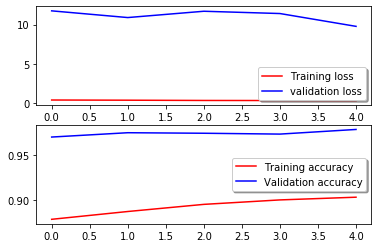

In [106]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='r', label="Training loss")
ax[0].plot(history.history['val_loss'], color='b', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='r', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [107]:
from sklearn.metrics import confusion_matrix